In [1]:
import pandas as pd
import geopandas as gpd
import ast
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point
import glob
import numpy as np
import matplotlib.ticker as mticker



In [2]:
property_type = 'Apartments' # 'Houses', 'Apartments', 'Offices'
                            # Houses are problematic. There are some houses in the data that have wrong coordinates
                            # Especially wrong for Buenos aires and La candelaria. 
                            # LA candelaria contains houses from la calera. Buenos aires from las palmas.
year = 2025
quarter = 1  # Change this to the desired quarter (1, 2, 3, or 4)


In [3]:

# Get all CSV files matching the pattern
csv_files = glob.glob(f'../../../data/{property_type}/listings_data_m2_medellin*.csv')


# Read and concatenate all CSV files into a single DataFrame
df = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)

In [4]:
# Convert 'Extraction Date' to datetime if not already
df['Extraction Date'] = pd.to_datetime(df['Extraction Date'])

# Selecting the deesired quarter
start_month = 3 * (quarter - 1) + 1
end_month = start_month + 2
mask = (
    (df['Extraction Date'].dt.year == year) &
    (df['Extraction Date'].dt.month >= start_month) &
    (df['Extraction Date'].dt.month <= end_month)
)
df =  df[mask]



# df

In [5]:
# Sort DataFrame by Extraction Date in descending order
df.sort_values('Extraction Date', ascending=False, inplace=True)


df.drop_duplicates(subset='propertyId', inplace=True, keep='first')

In [6]:

# Calculate price per square meter
df['price_per_m2'] = df['salePrice'] / df['area']

# Extract longitude and latitude from the 'coordinates' column
df['coordinates'] = df['coordinates'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['lon'] = df['coordinates'].apply(lambda x: x.get('lon') if isinstance(x, dict) else None)
df['lat'] = df['coordinates'].apply(lambda x: x.get('lat') if isinstance(x, dict) else None)

# Drop rows with missing coordinates
df = df[(df['lon'] != 0.0) & (df['lat'] != 0.0)]
df_map = df.dropna(subset=['lon', 'lat'])



In [7]:
# Load the shapefile
gdf = gpd.read_file('shp_barrios_y_veredas/barrios_y_veredas.shp')
# gdf = gdf.drop(columns=['fecha_actu'])
# gdf = gdf[~gdf['nombre'].isin([
#     'Corregimiento de San Sebastián de Palmitas',
#     'Corregimiento de San Cristóbal',
#     'Corregimiento de Altavista',
#     'Corregimiento de Santa Elena',
#     'Corregimiento de San Antonio de Prado',
#     'None'
# ])]

gdf_corregimientos = gpd.read_file('shp_comunas_y_corregimientos_/comunas_y_corregimientos_.shp')


gdf = gdf[gdf['nombre'].notna()]
display(gdf)
display(gdf_corregimientos)



codigo                                       nombre identifica  \
0    Inst_15                                        U.P.B    Inst_15   
1    Inst_18                               Cerro Nutibara    Inst_18   
2       0610                             Mirador del Doce       0610   
3       1620                       El Nogal-Los Almendros       1620   
4       0612                                   El Triunfo       0612   
..       ...                                          ...        ...   
327      AE6               Área de Expansión Belén Rincón       7097   
328     AUC1  Cabecera Urbana Corregimiento San Cristóbal       6000   
329     7007                      San José del Manzanillo       7007   
330     1510                                     Guayabal       1510   
331     9006                   Santa Elena Sector Central       9006   

    limitecomu limitemuni  subtipo_ba    Shape_Leng    Shape_Area  \
0           11        001           1   1872.110579  2.165193e+05   
1           16        001           1   2840.275369  3.991589e+05   
2           06        001           1   1336.347402  6.482238e+04   
3           16        001           1   3072.101126  2.483708e+05   
4           06        001           1   1730.001961  1.170693e+05   
..         ...        ...         ...           ...           ...   
327         70        001           2   4196.635540  3.327393e+05   
328         60        001           2   6870.676665  7.606237e+05   
329         70        001           2  11999.322834  2.072591e+06   
330         15        001           1   4132.420161  7.471615e+05   
331         90        001           2   9165.233263  3.228433e+06   

                                              geometry  
0    POLYGON ((4713613.195 2248705.932, 4713625.923...  
1    POLYGON ((4714984.017 2247909.523, 4715028.739...  
2    POLYGON ((4714157.227 2255420.732, 4714162.771...  
3    POLYGON ((4712900.496 2247841.179, 4712899.489...  
4    POLYGON ((4713973.756 2255960.81, 4713975.802 ...  
..                                                 ...  
327  POLYGON ((4711330.16 2245866.385, 4711330.656 ...  
328  POLYGON ((4708390.419 2252739.805, 4708390.526...  
329  POLYGON ((4711225.03 2245848.874, 4711225.553 ...  
330  POLYGON ((4714473.601 2243455.68, 4714417.29 2...  
331  POLYGON ((4725033.538 2244291.691, 4725001.762...  

[332 rows x 9 columns]

codigo                                      nombre        identifica  \
0      01                                     Popular          Comuna 1   
1      02                                  Santa Cruz          Comuna 2   
2      03                                    Manrique          Comuna 3   
3      04                                    Aranjuez          Comuna 4   
4      05                                    Castilla          Comuna 5   
5      06                             Doce de Octubre          Comuna 6   
6      07                                     Robledo          Comuna 7   
7      08                               Villa Hermosa          Comuna 8   
8      09                                Buenos Aires          Comuna 9   
9      10                               La Candelaria         Comuna 10   
10     11                            Laureles Estadio         Comuna 11   
11     12                                  La América         Comuna 12   
12     13                                  San Javier         Comuna 13   
13     14                                  El Poblado         Comuna 14   
14     16                                       Belén         Comuna 16   
15     50  Corregimiento de San Sebastián de Palmitas  Corregimiento 50   
16     60              Corregimiento de San Cristóbal  Corregimiento 60   
17     70                  Corregimiento de Altavista  Corregimiento 70   
18     90                Corregimiento de Santa Elena  Corregimiento 90   
19   SN02                                        None              None   
20     80       Corregimiento de San Antonio de Prado  Corregimiento 80   
21   SN01                                        None              None   
22     15                                    Guayabal         Comuna 15   

   limitemuni  subtipo_co fecha_actu    Shape_Leng    Shape_Area  \
0         001           1 2014-12-17   9604.447484  3.097941e+06   
1         001           1 2014-12-17   8597.293652  2.195663e+06   
2         001           1 2014-12-17  12077.558708  5.096182e+06   
3         001           1 2014-12-17   9642.676522  4.883314e+06   
4         001           1 2014-12-17  16098.031666  6.063916e+06   
5         001           1 2014-12-17  10709.846514  3.849812e+06   
6         001           1 2014-12-17  23265.232357  9.462008e+06   
7         001           1 2014-12-17  16392.858637  5.716968e+06   
8         001           1 2014-12-17  18364.901234  6.052668e+06   
9         001           1 2014-12-17  13632.701742  7.360811e+06   
10        001           1 2014-12-17  16365.175402  7.402669e+06   
11        001           1 2014-12-17  15425.496036  3.973307e+06   
12        001           1 2014-12-17  26384.222424  4.849279e+06   
13        001           1 2014-12-17  19965.688224  1.441432e+07   
14        001           1 2014-12-17  25695.015717  8.856232e+06   
15        001           2 2014-12-17  38399.211255  5.779920e+07   
16        001           2 2014-12-17  51162.616343  5.411279e+07   
17        001           2 2014-12-17  35012.583198  2.872578e+07   
18        001           2 2014-12-17  66527.054487  7.411415e+07   
19       None           2 2014-12-17   3897.791190  7.428364e+04   
20        001           2 2014-12-17  40472.283248  6.056777e+07   
21       None           1 2014-12-17  10025.597787  4.391447e+05   
22        001           1 2014-12-17  13279.241953  7.288421e+06   

                                             geometry  
0   POLYGON ((4718193.072 2255308.014, 4718201.801...  
1   POLYGON ((4717199.364 2255945.395, 4717204.765...  
2   POLYGON ((4718792.583 2253310.702, 4718793.392...  
3   POLYGON ((4716607.297 2253867.449, 4716615.853...  
4   POLYGON ((4716246.187 2256230.621, 4716254.135...  
5   POLYGON ((4715116.584 2256050.193, 4715118.535...  
6   POLYGON ((4713487.934 2254398.619, 4713489.256...  
7   POLYGON ((4717867.132 2250665.308, 4717873.3 2...  
8   POLYGON ((4717386.83 2248752.267, 4717387.947 ...  
9   POLYG

In [ ]:
# Get the geometry for 'El Poblado' from gdf_corregimientos
el_poblado_geom = gdf_corregimientos[gdf_corregimientos['nombre'] == 'El Poblado']['geometry'].iloc[0]

# Filter subneighbourhoods in gdf that are within 'El Poblado' or named 'La Aguacatala'
gdf_el_poblado = gdf[gdf.within(el_poblado_geom) | 
                    (gdf['nombre'] == 'La Aguacatala') |
                    (gdf['nombre'] == 'Santa Maria de Los Angeles') |
                    (gdf['nombre'] == 'El Tesoro') ].copy()

                    # Santa Maria de Los Angeles' and "El Tesoro"

gdf_el_poblado

In [34]:
# Get the geometry for 'El Poblado' from gdf_corregimientos
el_poblado_geom = gdf_corregimientos[gdf_corregimientos['nombre'] == 'El Poblado']['geometry'].iloc[0]

# Filter subneighbourhoods in gdf that are within 'El Poblado'
#### xxx i am missing "La Aguacatala", 'Santa Maria de Los Angeles' and "El Tesoro"
gdf_el_poblado = gdf[gdf.within(el_poblado_geom)].copy()

gdf_el_poblado

codigo             nombre identifica limitecomu limitemuni  subtipo_ba  \
11    1408  Altos del Poblado       1408         14        001           1   
15    1401    Barrio Colombia       1401         14        001           1   
43    1421       Patio Bonito       1421         14        001           1   
48    1413   El Diamante No.2       1413         14        001           1   
62    1406     Las Lomas No.1       1406         14        001           1   
73    1417         La Florida       1417         14        001           1   
80    1420            Astorga       1420         14        001           1   
118   1416         Alejandría       1416         14        001           1   
122   1410       Los Naranjos       1410         14        001           1   
137   1407     Las Lomas No.2       1407         14        001           1   
154   1412          San Lucas       1412         14        001           1   
168   1405            Lalinde       1405         14        001           1   
179   1414        El Castillo       1414         14        001           1   
183   1418         El Poblado       1418         14        001           1   
194   1404          Castropol       1404         14        001           1   
224   1411    Los Balsos No.1       1411         14        001           1   
225   1403      Villa Carlota       1403         14        001           1   
253   1415    Los Balsos No.2       1415         14        001           1   
258   1419             Manila       1419         14        001           1   

      Shape_Leng    Shape_Area  \
11   5263.333631  9.108599e+05   
15   2849.568679  4.016539e+05   
43   4102.003583  7.290101e+05   
48   3742.168950  6.609916e+05   
62   2988.809110  4.861042e+05   
73   4065.076227  7.676061e+05   
80   2005.415571  2.222017e+05   
118  2774.603941  4.321206e+05   
122  5219.374079  9.652851e+05   
137  2760.586161  3.357227e+05   
154  5107.652619  1.228248e+06   
168  2274.122577  2.300418e+05   
179  3760.422844  7.227048e+05   
183  2739.340964  2.614129e+05   
194  3958.106961  6.061262e+05   
224  5917.504343  1.403506e+06   
225  3942.413161  9.351430e+05   
253  2946.429812  4.863252e+05   
258  2454.666142  2.741204e+05   

                                              geometry  
11   POLYGON ((4717778.465 2245375.095, 4717778.242...  
15   POLYGON ((4715785.582 2246825.663, 4715792.962...  
43   POLYGON ((4715091.837 2245226.474, 4715084.823...  
48   POLYGON ((4715537.3 2242203.311, 4715565.921 2...  
62   POLYGON ((4716735.077 2245444.986, 4716744.622...  
73   POLYGON ((4716384.99 2244612.225, 4716390.682 ...  
80   POLYGON ((4715658.975 2244950.482, 4715628.265...  
118  POLYGON ((4716310.74 2243825.122, 4716297.936 ...  
122  POLYGON ((4717071.492 2243652.695, 4717074.92 ...  
137  POLYGON ((4717019.01 2245382.61, 4717040.278 2...  
154  POLYGON ((4716034.981 2242361.398, 4716036.98 ...  
168  POLYGON ((4716433.384 2245440.951, 4716435.561...  
179  POLYGON ((4716000.703 2242872.291, 4715967.917...  
183  POLYGON ((4716384.99 2244612.225, 4716387.587 ...  
194  POLYGON ((4716243.676 2246502.324, 4716251.774...  
224  POLYGON ((4716963.138 2242868.385, 4716964.825...  
225  POLYGON ((4715802.615 2246318.602, 4715800.154...  
253  POLYGON ((4716141.044 2243331.341, 4716138.579...  
258  POLYGON ((4715718.324 2245409.175, 4715717.165...

<Axes: >

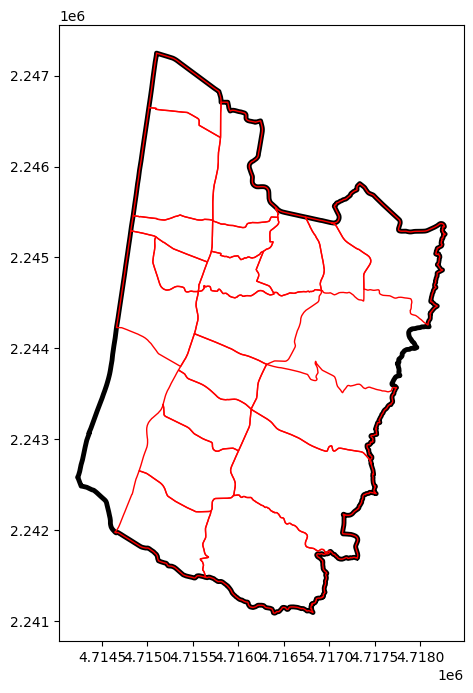

In [29]:
# Set the map provider for the basemap
map_provider = 'OPNVKarte'

# Create the figure and axis for plotting
fig, ax = plt.subplots(figsize=(12, 8))


# Plot the valid neighbourhoods colored by median price

# Draw the edges of all neighbourhoods (including those without data)
gdf_corregimientos[gdf_corregimientos['nombre']=='El Poblado'].plot(facecolor='none', ax=ax, edgecolor='k', linewidth=3.5)

gdf_el_poblado.plot(facecolor='none', ax=ax, edgecolor='r')


In [8]:

# Ensure gdf is in the same CRS as the coordinates (EPSG:4326)
gdf_4326 = gdf.to_crs(epsg=4326)

# Create geometry column in df_map
df_map['geometry'] = df_map.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

# Convert df_map to GeoDataFrame
gdf_points = gpd.GeoDataFrame(df_map, geometry='geometry', crs='EPSG:4326')

# Spatial join to get neighbourhood names
gdf_points = gpd.sjoin(gdf_points, gdf_4326[['nombre', 'geometry']], how='left', predicate='within')

# Add the neighbourhood name from gdf as a new column
df_map['neighbourhood_from_shape'] = gdf_points['nombre']

/tmp/ipykernel_661466/1551281998.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_map['geometry'] = df_map.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
/tmp/ipykernel_661466/1551281998.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_map['neighbourhood_from_shape'] = gdf_points['nombre']


In [9]:
# Calculate average and median salePrice for each neighbourhood in df_map
avg_price_by_neigh = df_map.groupby('neighbourhood_from_shape')['salePrice'].mean()
median_price_by_neigh = df_map.groupby('neighbourhood_from_shape')['salePrice'].median()

# Calculate the Semi-Interquartile Range (SIQR) for each neighbourhood
q1 = df_map.groupby('neighbourhood_from_shape')['salePrice'].quantile(0.25)
q3 = df_map.groupby('neighbourhood_from_shape')['salePrice'].quantile(0.75)
siqr_by_neigh = (q3 - q1) / 2

# Map SIQR to the gdf_4326 GeoDataFrame
gdf_4326['siqr'] = gdf_4326['nombre'].map(siqr_by_neigh)


# Calculate the number of properties per neighbourhood
count_by_neigh = df_map.groupby('neighbourhood_from_shape')['salePrice'].count()
gdf_4326['num_properties'] = gdf_4326['nombre'].map(count_by_neigh).fillna(0).astype(int)

# Map the average price to the gdf_4326 GeoDataFrame based on 'nombre'
gdf_4326['avg_price'] = gdf_4326['nombre'].map(avg_price_by_neigh)
gdf_4326['median_price'] = gdf_4326['nombre'].map(median_price_by_neigh)


# If the number of properties is less than 5, make the avg_price equal to nan
min_properties = 1
gdf_4326.loc[gdf_4326['num_properties'] < min_properties, 'avg_price'] = np.nan
gdf_4326.loc[gdf_4326['num_properties'] < min_properties, 'median_price'] = np.nan


# gdf_4326['avg_price'] = gdf_4326['avg_price'].fillna(0)

# gdf_4326

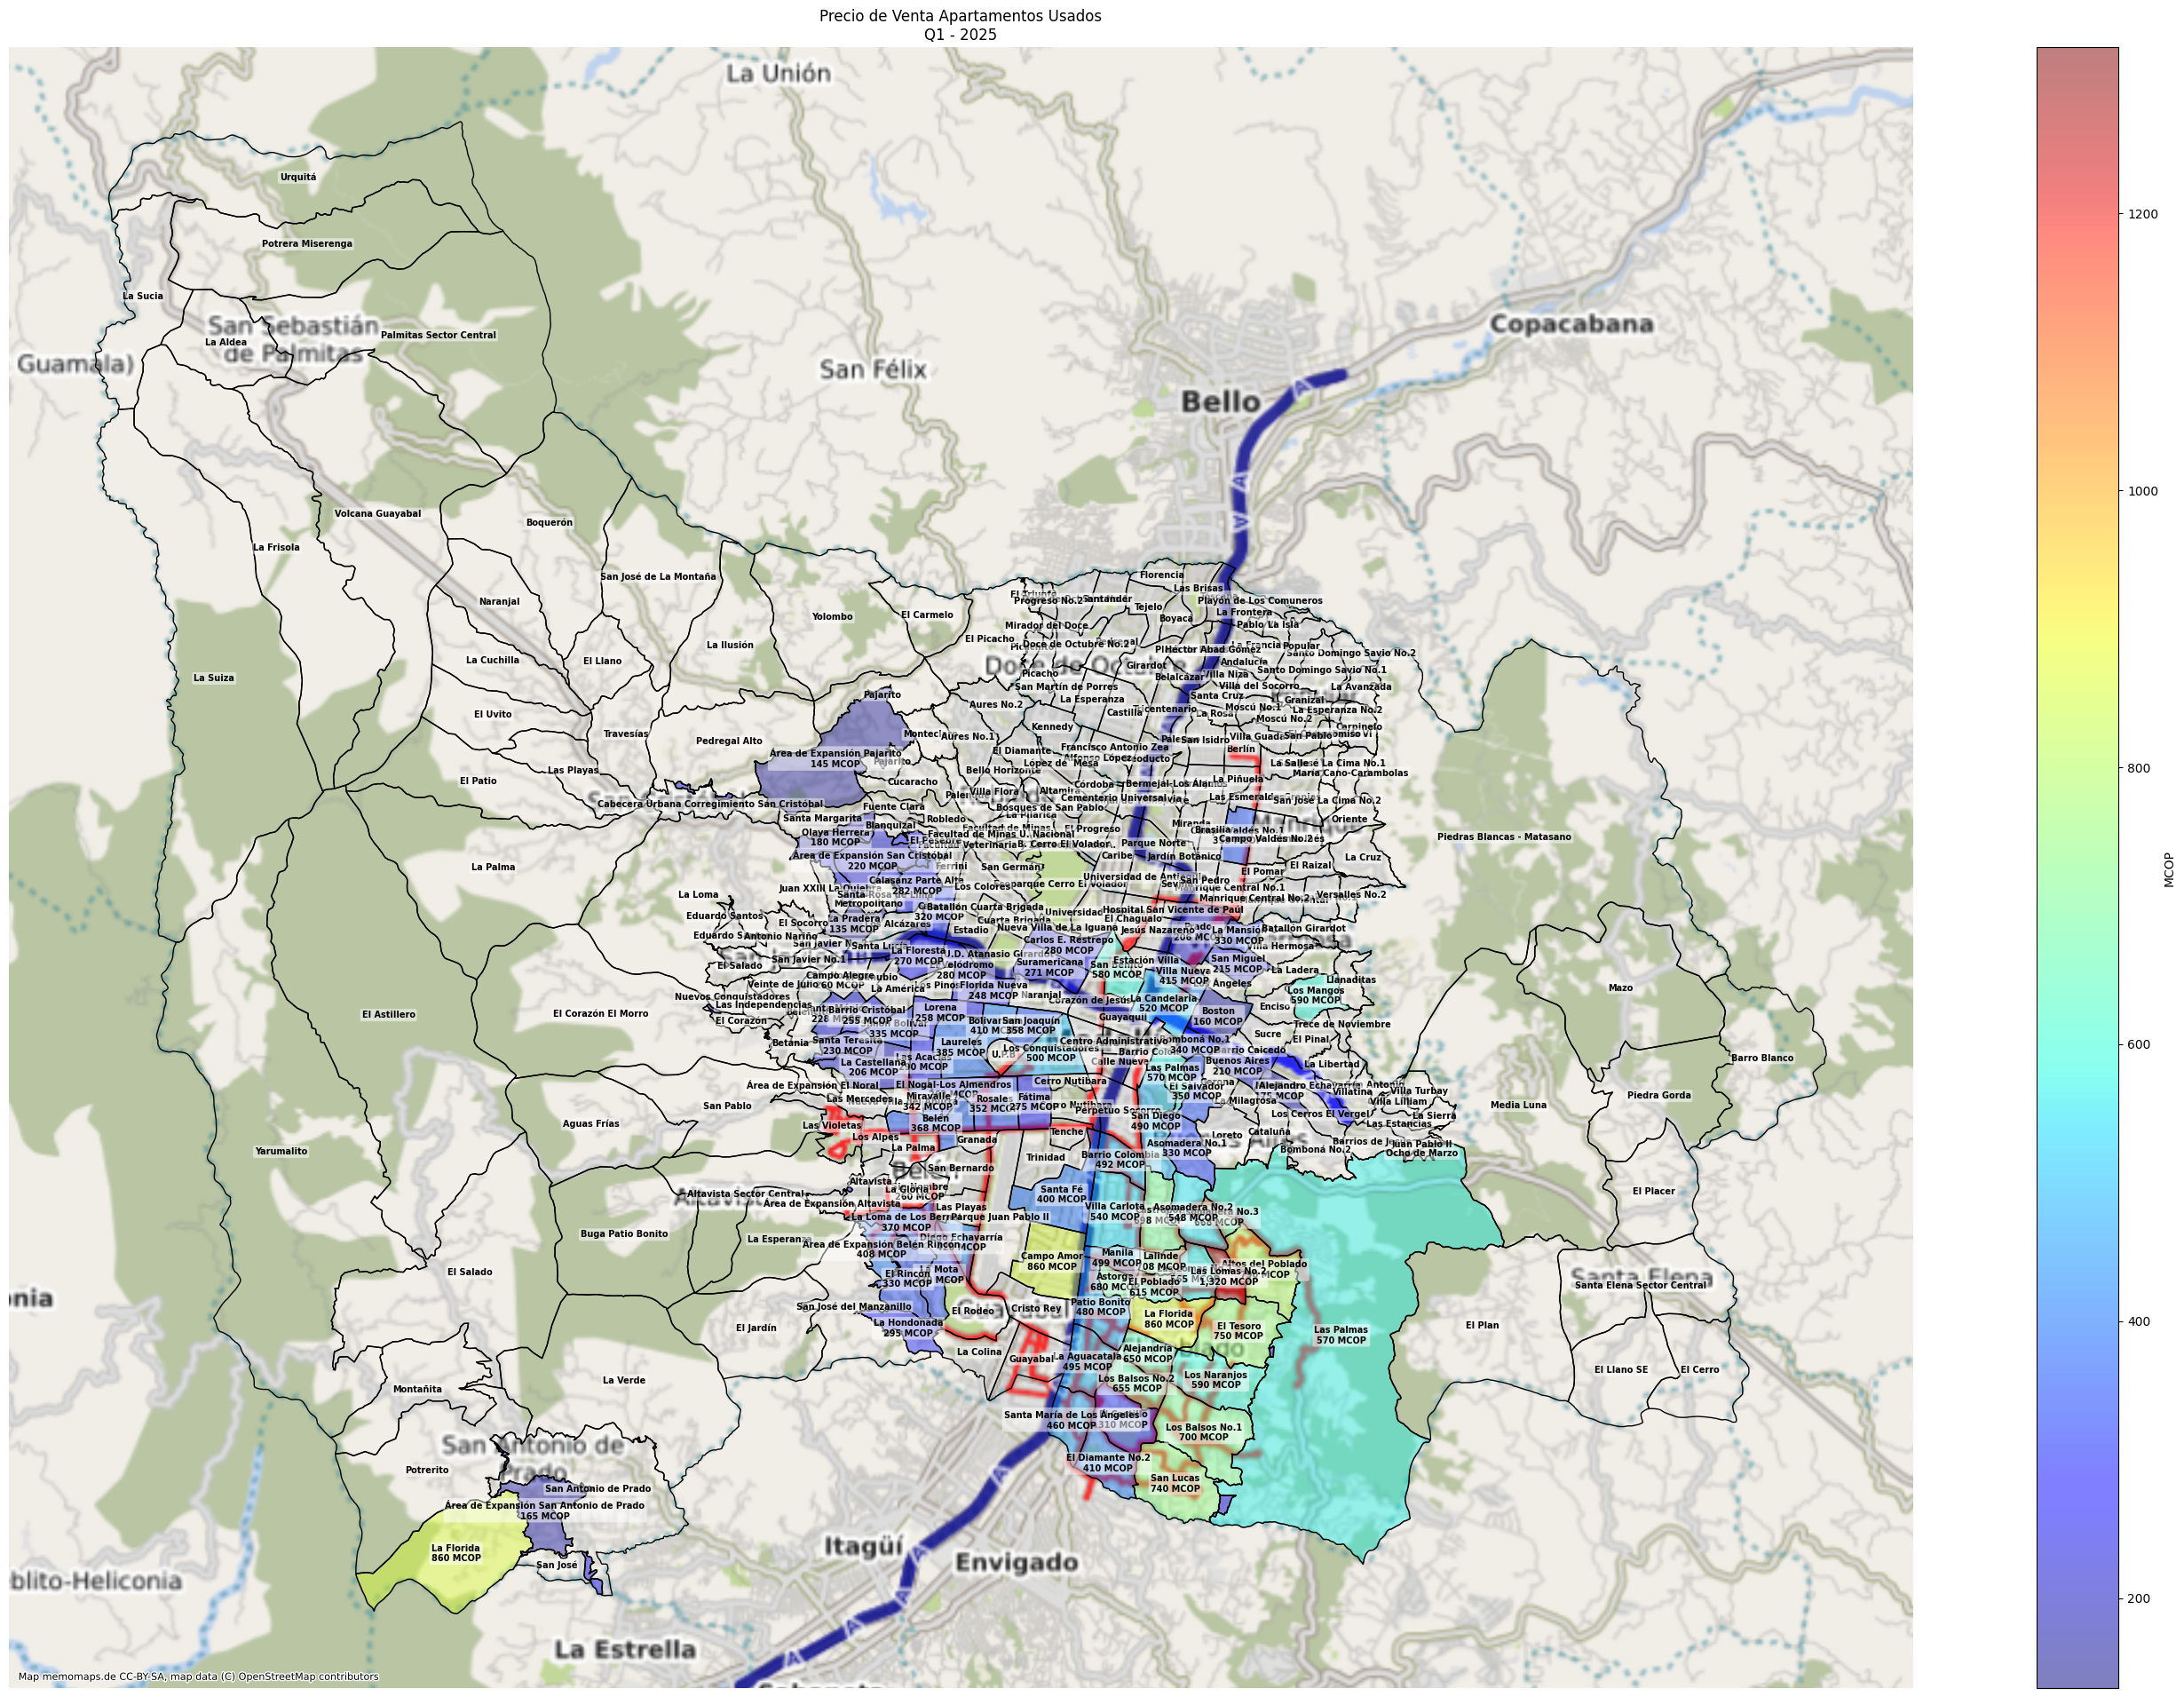

In [32]:
# Set the map provider for the basemap
map_provider = 'OPNVKarte'

# Create the figure and axis for plotting
fig, ax = plt.subplots(figsize=(36, 24))

# Filter neighbourhoods with valid (non-NaN, non-zero) median prices
gdf_4326_valid = gdf_4326[gdf_4326['median_price'].notna() & (gdf_4326['median_price'] != 0)]

# Plot the valid neighbourhoods colored by median price
plot = gdf_4326_valid.plot(
    column='median_price', ax=ax, legend=True, cmap='jet', edgecolor='k', alpha=0.4
)

# Draw the edges of all neighbourhoods (including those without data)
gdf_4326.plot(facecolor='none', ax=ax, edgecolor='k')
# df_map.plot.scatter(x='lon', y='lat', ax=ax, c='red', s=10, alpha=0.7, label='Properties')


# Add the basemap tiles to the plot
source = ctx.providers[map_provider]
ctx.add_basemap(ax, crs=gdf_4326.crs.to_string(), source=source)

# Set the plot title and remove axis
if property_type == 'Apartments':
    property_type_label = 'Apartamentos Usados'
elif property_type == 'Houses':
    property_type_label = 'Casas Usadas'
elif property_type == 'Offices':
    property_type_label = 'Oficinas Usadas'


plt.title(f'Precio de Venta {property_type_label}\nQ{quarter} - {year}')
plt.axis('off')

# Format the colorbar to show values in millions of COP
alpha_value = 0.5
cbar = plot.get_figure().axes[-1]
cbar.set_ylabel('MCOP')
cbar.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e6:.0f}'))
for c in cbar.collections:
    c.set_alpha(alpha_value)


# Annotate each neighbourhood
for idx, row in gdf_4326.iterrows():
    centroid = row['geometry'].centroid
    neighbourhood_name = row['nombre']
    median_price = row['median_price']
    if not np.isnan(median_price) and median_price != 0:
        value = median_price / 1e6
        label = f'{neighbourhood_name}\n{value:,.0f} MCOP'
    else:
        label = f'{neighbourhood_name}'
    ax.annotate(
        label,
        (centroid.x, centroid.y),
        color='black',
        fontsize=7,
        ha='center',
        va='center',
        fontweight='bold',
        bbox=dict(facecolor='white', alpha=alpha_value, edgecolor='none', boxstyle='round,pad=0.2')
    )

# Display the plot
plt.show()


In [11]:
gdf_4326_valid

codigo                                  nombre identifica limitecomu  \
3     1620                  El Nogal-Los Almendros       1620         16   
11    1408                       Altos del Poblado       1408         14   
15    1401                         Barrio Colombia       1401         14   
16    1602                                 Rosales       1602         16   
19    1507                              Campo Amor       1507         15   
..     ...                                     ...        ...        ...   
282    AE7  Área de Expansión San Antonio de Prado       8098         80   
298   1117                           Florida Nueva       1117         11   
302   1015                            Bomboná No.1       1015         10   
324    AE2         Área de Expansión San Cristóbal       6097         60   
327    AE6          Área de Expansión Belén Rincón       7097         70   

    limitemuni  subtipo_ba   Shape_Leng    Shape_Area  \
3          001           1  3072.101126  2.483708e+05   
11         001           1  5263.333631  9.108599e+05   
15         001           1  2849.568679  4.016539e+05   
16         001           1  3271.843727  6.050484e+05   
19         001           1  4274.711736  1.037003e+06   
..         ...         ...          ...           ...   
282        001           2  7322.414325  8.672008e+05   
298        001           1  2134.049815  2.491013e+05   
302        001           1  1990.578023  2.072714e+05   
324        001           2  5067.954848  7.217845e+05   
327        001           2  4196.635540  3.327393e+05   

                                              geometry          siqr  \
3    POLYGON ((-75.59551 6.23662, -75.59552 6.2366,...  3.875000e+07   
11   POLYGON ((-75.55134 6.21454, -75.55134 6.21453...  1.983746e+08   
15   POLYGON ((-75.56941 6.22756, -75.56934 6.22734...  1.250000e+06   
16   POLYGON ((-75.58727 6.23167, -75.58734 6.23167...  8.437500e+07   
19   POLYGON ((-75.57763 6.21688, -75.57772 6.21626...  0.000000e+00   
..                                                 ...           ...   
282  POLYGON ((-75.6559 6.18236, -75.65587 6.18236,...  0.000000e+00   
298  POLYGON ((-75.5878 6.25313, -75.58783 6.25305,...  3.750000e+06   
302  POLYGON ((-75.55827 6.24366, -75.55824 6.24365...  4.868750e+07   
324  POLYGON ((-75.60659 6.27458, -75.6066 6.27457,...  0.000000e+00   
327  POLYGON ((-75.60961 6.21869, -75.60961 6.21869...  4.125000e+07   

     num_properties     avg_price  median_price  
3                 2  2.625000e+08   262500000.0  
11                7  9.224667e+08   790000000.0  
15                2  4.925000e+08   492500000.0  
16                4  3.362500e+08   352500000.0  
19                1  8.600000e+08   860000000.0  
..              ...           ...           ...  
282               1  1.650000e+08   165000000.0  
298               2  2.475000e+08   247500000.0  
302               4  3.523750e+08   340000000.0  
324               1  2.200000e+08   220000000.0  
327               2  4.075000e+08   407500000.0  

[80 rows x 13 columns]

In [12]:
tmp_to_plot = df_map[(df_map['neighbourhood_from_shape'] == 'La Candelaria') & (df_map['salePrice'] > 1e9)]
print(tmp_to_plot.iloc[1]['link'])
print(tmp_to_plot.iloc[0]['link'])
tmp_to_plot[['neighborhood',	'commonNeighborhood', 'neighbourhood_from_shape']]

IndexError: single positional indexer is out-of-bounds

In [ ]:
fig, ax = plt.subplots(figsize=(24, 20))
gdf_4326.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=0.8, alpha=0.5)


tmp_to_plot.plot.scatter(
    x='lon',
    y='lat',
    ax=ax,
    c=tmp_to_plot['salePrice'],
    cmap='jet',
    s=100,
    alpha=0.7,
    label='Properties',
    colorbar=True
)
ctx.add_basemap(ax, crs='EPSG:4326', source=source)
plt.title('Property Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()